In [1]:
from pipeline.data_access.dao.sussex_huawei_dao import SussexHuaweiDAO
from pipeline.feature_engineering.preprocessing.sussex_huawei_preprocessor import SussexHuaweiPreprocessor
from pipeline.feature_engineering.feature_extraction.baseline_extractor import BaselineExtractor
import matplotlib as plt
import seaborn as sns

In [2]:
dao = SussexHuaweiDAO()
preprocessor = SussexHuaweiPreprocessor()
extractor = BaselineExtractor()

In [3]:
# 1. Load Data
label_column_names = ['coarse_label', 'fine_label', 'road_label']
labels = dao.read_data(
            './data_sets/sussex_huawei/User1/220617/Label.txt', #TODO: Pack in config/.env
            column_names=label_column_names, use_columns=[1, 2, 3])
data_column_names = ['time', 'acceleration_x', 'acceleration_y', 'acceleration_z', #TODO: Pack in config/.env
                             #'gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                             #'magnetometer_x', 'magnetometer_y', 'magnetometer_z',
                             'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z',
                             'gravity_x', 'gravity_y', 'gravity_z',
                             #'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z',
                             ]
data = dao.read_data(
        './data_sets/sussex_huawei/User1/220617/Hand_Motion.txt', #TODO: Pack in config/.env
        column_names=data_column_names, use_columns=[0,1,2,3,10,11,12,13,14,15,16]) #4,5,6,7,8,9,17,18,19


In [4]:
# 2. Preprocessing

# 2.1 Convert unix time (ms) to date time
data = preprocessor.convert_unix_to_datetime(data, column = 'time', unit = 'ms')

# 2.2 Label data and remove NaNs
data = preprocessor.label_data(data, labels)
data = preprocessor.remove_nans(data, replacement_mode='del_row')

# 2.3 Normalization
acelerometer_columns = ['acceleration_x', 'acceleration_y', 'acceleration_z']
gravity_columns = ['gravity_x', 'gravity_y', 'gravity_z']
orientation_columns = ['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='gravity', 
            target_columns = acelerometer_columns,
            args = gravity_columns)

data = preprocessor.project_accelerometer_to_global_coordinates(
            data, 
            mode ='orientation', 
            target_columns = acelerometer_columns,
            args = orientation_columns)


#data = preprocessor.znormalize_quantitative_data(data, data_column_names[1:])
#data = preprocessor.min_max_normalize_quantitative_data(data, data_column_names[1:])

# 2.4 Segment data
# Coarse Label: Null=0, Still=1, Walking=2, Run=3, Bike=4, Car=5, Bus=6, Train=7, Subway=8
# Road Label: City=1, Motorway=2, Countryside=3, Dirt road=4, Null=0
selected_coarse_labels = [5]
selected_road_labels = [1, 3]
car_segments = preprocessor.segment_data(data, mode='labels', 
                                 label_column='coarse_label', 
                                 args=selected_coarse_labels)

data_segments = []
for car_segment in car_segments:
        road_segments = preprocessor.segment_data(car_segment, mode='labels', 
                                  label_column='road_label',
                                  args=selected_road_labels
                                )
        for road_segment in road_segments:
            data_segments.append(road_segment)
            
# 2.5 Low Pass filtering -> #100 Hz to 10 Hz
for ind in range(len(data_segments)):
    data_segments[ind] = data_segments[ind].set_index('time')
    data_segments[ind] = preprocessor.resample_quantitative_data(data_segments[ind], freq='1000ms')
    
# 2.6 Outlier removal:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.remove_outliers_from_quantitative_data(
        data_segments[ind],
        replacement_mode = 'quantile',
        columns = acelerometer_columns,
        quantile = 0.99
    )
    
# 2.7 Dimensionality reduction:
for ind in range(len(data_segments)):
    data_segments[ind] = preprocessor.reduce_quantitativ_data_dimensionality(
        data = data_segments[ind],
        mode ='euclidean',
        columns = acelerometer_columns,
        reduced_column_name = 'acceleration_abs'
    )

1


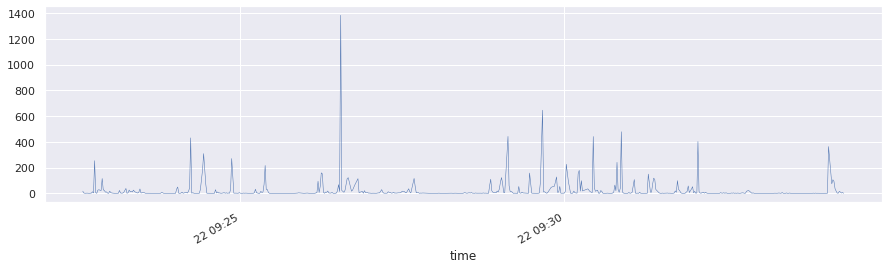

In [5]:
# Visual anlaysis:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[0]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[0]['road_label'].iloc[0]); # 1 = City

3


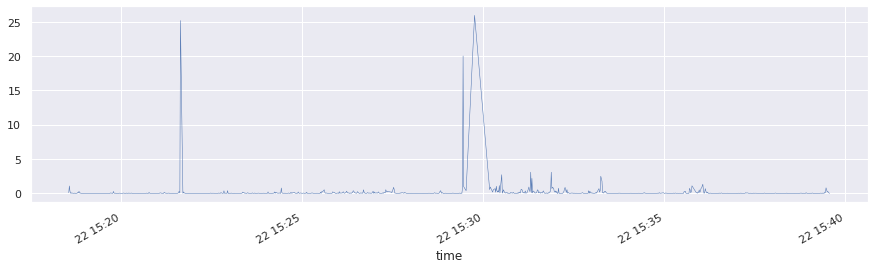

In [6]:
sns.set(rc={'figure.figsize':(15, 4)})
data_segments[5]['acceleration_abs'].plot(linewidth=0.5);
print(data_segments[5]['road_label'].iloc[0]); # 3 = Country

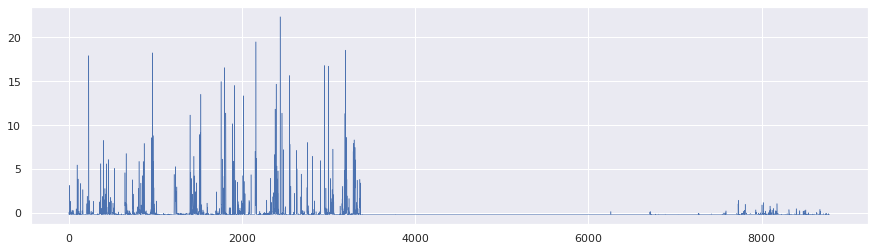

In [7]:
# 3. Feature Extraction

#3.1 Prepare for Basline Extractor
selected_columns = ['acceleration_abs', 'road_label']
data = preprocessor.de_segment_data(data_segments, selected_columns)
data = preprocessor.znormalize_quantitative_data(data, ['acceleration_abs'])
data['acceleration_abs'].plot(linewidth=0.5);


In [8]:
#Encode categorical to binary
data = preprocessor.encode_categorical_features(data = data, 
                                                mode = 'custom_function', 
                                                columns = ['road_label'],
                                                encoding_function = lambda x :  (x  > 2.0).astype(int)
                                               )


# Generate label vector y and feature matrix X.
# We need at least 2 classes to learn features for tsfresh
y = data[['road_label']].reset_index(drop=True)
data['id'] = range(1, len(data) + 1)
y['id'] = data['id']
y['road_label'].index=list(y['id'])

# 3.2 Extract feature matrix
# Read https://github.com/blue-yonder/tsfresh/issues/444 for info about the warnings
X = extractor.extract_features(data = data, args = ['id', y['road_label'], 16])

Feature Extraction: 100%|██████████| 80/80 [00:53<00:00,  1.51it/s]
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'acceleration_abs__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 ... 'road_label__spkt_welch_density__coeff_2'
 'road_label__spkt_welch_density__coeff_5'
 'road_label__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [93]:
# 4. Train and select a model from sklearn

# 4.1 Random Forrests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import learning_curve
import numpy

keys = X.keys()
keys = list(filter(lambda x: "acceleration_abs" in x, keys))
for key in keys:
    print(key) 

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1)
#clf.fit(X[keys], y)  
#clf.prdict(X)

# Score function of sklearns RandomForrests classifier that is called by cross_val_score:
# "Returns the mean accuracy on the given test data and labels.""
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
tscv = TimeSeriesSplit(n_splits=10)
score = cross_validate(clf, X[keys], y['road_label'], cv=tscv)
print(score)

#train_sizes, train_scores, test_scores = learning_curve(
#    clf, X[keys], y['road_label'], cv=tscv, n_jobs=16, train_sizes=numpy.linspace(.1, 1.0, 5))

acceleration_abs__quantile__q_0.9
acceleration_abs__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10
acceleration_abs__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2
acceleration_abs__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20
acceleration_abs__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5
acceleration_abs__fft_coefficient__coeff_0__attr_"real"
acceleration_abs__maximum
acceleration_abs__mean
acceleration_abs__median
acceleration_abs__minimum
acceleration_abs__quantile__q_0.1
acceleration_abs__quantile__q_0.2
acceleration_abs__quantile__q_0.3
acceleration_abs__quantile__q_0.4
acceleration_abs__quantile__q_0.6
acceleration_abs__quantile__q_0.7
acceleration_abs__quantile__q_0.8
acceleration_abs__sum_values
acceleration_abs__abs_energy
acceleration_abs__fft_coefficient__coeff_0__attr_"abs"
acceleration_abs__fft_coefficient__coeff_0__attr_"angle"
acceleration_abs__range_count__max_1000000000000.0__min_0
acceleration_abs__range_count__max_1__min_-1
{'fit_tim

In [92]:
#sns.plot(linewidth=0.5);

AttributeError: module 'seaborn' has no attribute 'plot'

In [38]:
# 4.2 Super Vector Machine (SVM)
from sklearn.svm import SVC
clf = SVC(gamma='auto')


score = cross_validate(clf, X[keys], y['road_label'], cv=10)
print(score)

{'fit_time': array([2.54224682, 2.45371771, 2.47183394, 2.44762969, 2.56870818,
       2.67822838, 2.43495536, 2.44809198, 2.42139363, 2.42837095]), 'score_time': array([0.2060163 , 0.20569968, 0.20870948, 0.20945668, 0.26778531,
       0.20656228, 0.20769715, 0.21254802, 0.21064496, 0.2078073 ]), 'test_score': array([0.59772727, 0.59772727, 0.59772727, 0.59794989, 0.59794989,
       0.59794989, 0.59794989, 0.59794989, 0.59794989, 0.59794989])}


In [39]:
# 4.3  CART Decision Tree (similar to C4.5)
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

score = cross_validate(clf, X[keys], y['road_label'], cv=tscv)
print(score)

{'fit_time': array([0.00306129, 0.00227189, 0.00235367, 0.00233531, 0.00239658,
       0.04580307, 0.05646896, 0.08132076, 0.11789751, 0.13256502]), 'score_time': array([0.00098872, 0.00095797, 0.00095892, 0.00090623, 0.00090384,
       0.00062871, 0.00063586, 0.00065112, 0.00063968, 0.00066948]), 'test_score': array([1.        , 1.        , 1.        , 1.        , 0.62280702,
       0.06015038, 0.28571429, 0.40977444, 0.63533835, 0.59899749])}


In [80]:
# 4.4 Multi Layered Perceptron
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,2), random_state=1)


score = cross_validate(clf, X[keys], y['road_label'], cv=tscv)
print(score)

{'fit_time': array([0.00758743, 0.00549459, 0.01450038, 0.01994014, 0.02329731,
       0.01387787, 0.01477671, 0.01425529, 0.01458764, 0.01495719]), 'score_time': array([0.00095916, 0.0007081 , 0.00187135, 0.00201273, 0.00206423,
       0.00204182, 0.00182009, 0.00179887, 0.00176883, 0.0017004 ]), 'test_score': array([1.        , 1.        , 1.        , 1.        , 0.62280702,
       0.        , 0.        , 0.        , 0.31704261, 0.63283208])}


In [ ]:
# 5. Train and select a model from tslearn

# 5.1 KNN voting classifier
#from tslearn.neighbors import KNeighborsTimeSeriesClassifier
#X.drop(X.tail(len(X)-50).index,inplace=True)
#y.drop(y.tail(len(y)-50).index,inplace=True)
#clf = KNeighborsTimeSeriesClassifier(n_jobs = 16, n_neighbors=2, metric="dtw")
#score = cross_validate(clf, X, y['road_label'], cv=tscv)

#Note: This takes an eternity to predict. 

In [41]:
# 5.2 Time Series SVC

from tslearn.svm import TimeSeriesSVC
clf = TimeSeriesSVC(n_jobs = 16, kernel="gak", gamma="auto", probability=True)
clf.fit(X[keys], y['road_label'])
clf.predict(X[keys]).shape

/home/lorenz/miniconda3/envs/rctc/lib/python3.7/site-packages/tslearn/utils.py:63: UserWarning: 2-Dimensional data passed. Assuming these are 8786 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


KeyboardInterrupt: 